In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np
import torch
import torch.nn.functional as F

SQ = np.sqrt(2) / 2

make_normal = torch.Tensor([
    [ 0,  1,  0,  -1],
    [-1,  0,  1,   0],
    [-SQ, -SQ,  SQ,  SQ],
    [ SQ, -SQ, -SQ,  SQ],
    [ SQ, -SQ, -SQ,  SQ],
    [ SQ,  SQ, -SQ, -SQ],
]).T

target = torch.rand(41, 41) * 0.2
for d in range(10):
    target[10:20-d, 10+d] = 1 - target[10:20-d, 10+d]
    target[20+d:30, 30-d] = 1 - target[20+d:30, 30-d]
target[:10,:] = 1 - target[:10,:]
target[25:,:] = 1 - target[25:,:]

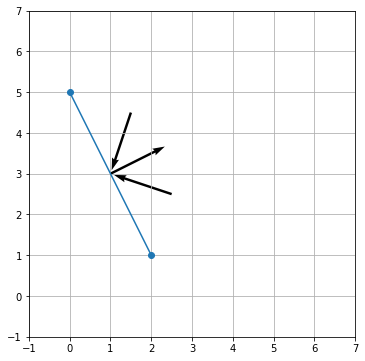

In [2]:
## Make normals
AB = np.array([0, 5, 2, 1])
A, B = AB.reshape(2, 2)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim([-1, 7])
ax.set_ylim([-1, 7])
plt.grid()
plt.plot(*zip(A, B), '-o')

nor = AB @ make_normal.numpy()
normals = nor.reshape(3, 2)

def arrow(start, direction):
    plt.quiver(start[[0]], start[[1]], direction[[0]], direction[[1]], scale=3, units='xy')

C = (A + B + normals[0]) / 2
arrow((A + B) / 2, normals[0])
arrow((A + C) / 2, normals[1])
arrow((B + C) / 2, normals[2])

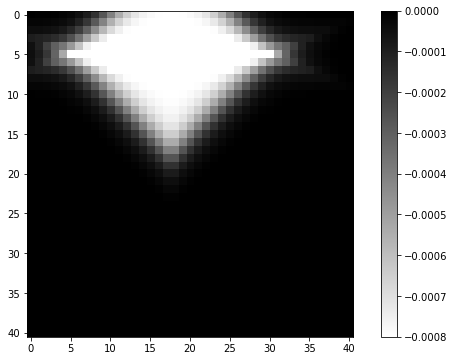

In [13]:
def edge_loss(edges, target):
    normals = torch.matmul(edges, make_normal)
    normals = normals.view(-1, 3, 2) # split up the 3 normals
    
    sizes = torch.pow(normals, 2).sum(dim=2, keepdims=True)
    
    normals = normals / sizes.sqrt()
    normals = normals.view(-1, 6) # rejoin the 3 normals
    
    dists_left  = (edges[:,[0,1,0,1,2,3]] * normals).view(-1, 3, 2).sum(dim=2)
    dists_right = (edges[:,[0,1,2,3,0,1]] * normals).view(-1, 3, 2).sum(dim=2)
    
    ly = torch.arange(target.shape[0]).float()
    lx = torch.arange(target.shape[1]).float()
    grid = torch.stack(torch.meshgrid(ly, lx), dim=-1)
    
    # Expand everything along to Batch x edge x HW x xy
    bc_grid = grid.view(-1, 2).unsqueeze(0).unsqueeze(0)
    bc_normals = normals.view(-1, 3, 2, 1)
    bc_dists_left = dists_left.unsqueeze(2).unsqueeze(3)
    bc_dists_right = dists_right.unsqueeze(2).unsqueeze(3)
    
    dotprods = torch.matmul(bc_grid, bc_normals).squeeze(2)
    
    sdf = dotprods - bc_dists_left
    sdf = sdf.view(-1, 3, *target.shape)
    sdf = torch.min(sdf, dim=1)[0]
    leftness = torch.sigmoid(sdf) / sizes[:,[0]]
    
    sdf = -(dotprods - bc_dists_right)
    sdf = sdf.view(-1, 3, *target.shape)
    sdf = torch.min(sdf, dim=1)[0]
    rightness = torch.sigmoid(sdf) / sizes[:,[0]]
    
    target = target.unsqueeze(0)
    # loss = -insideness * target - outsideness * (1 - target)
    loss = (-leftness * target - rightness * (1 - target)) 
    
    return loss.mean(), loss, locals()

#                    x1 y1 x2 y2
edges = torch.Tensor([[5, 5, 5, 30]]).repeat(17, 1)
edges.requires_grad = True

_loss, _loss_surf, _locals = edge_loss(edges, 0.5 * torch.ones_like(target))
# print(_insideness.min().item(), _insideness.max().item())
plt.imshow(_loss_surf.detach()[0], cmap='gray_r')
plt.colorbar()

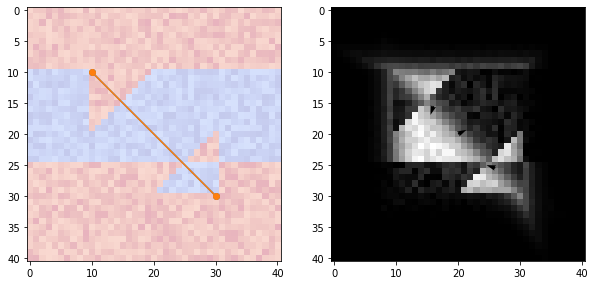

In [85]:
#                    x1 y1 x2 y2
edges = torch.Tensor([[10, 10, 30, 30]])
edges.requires_grad = True
opt = torch.optim.Adam([edges], 5e-2)

# initialization function: plot the background of each frame
fig, (ax1, ax2) = plt.subplots(1, 2)

_loss, _loss_surf, _locals = edge_loss(edges, target)
trgt = ax1.imshow(target.detach(), cmap='coolwarm', alpha=0.3)
ins = ax2.imshow(_loss_surf.detach()[0], cmap='gray_r')
t = edges.detach()[0]
line, = ax1.plot([t[1], t[3]], [t[0], t[2]], 'o-')

A, B = edges[0].detach().numpy().reshape(2, 2)
ax1.plot(*zip(A, B), '-o')
C = (A + B + normals[0]) / 2
arrow((A + B) / 2, normals[0])
arrow((A + C) / 2, normals[1])
arrow((B + C) / 2, normals[2])

def init():
    t = edges.detach()[0]
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    return (line, ins, )

def animate(i):
    for _ in range(2):
        opt.zero_grad()
        loss, _loss_surf = edge_loss(edges, target)
        loss.backward()
        opt.step()
    t = edges.detach()[0]
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    ins.set_data(_loss_surf.detach()[0])
    
    return (line, ins, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)

In [73]:
HTML(anim.to_html5_video())

In [27]:
make_normal = -torch.Tensor([
    [0, -1, 0, 1],
    [1, 0, -1, 0]
]).T

target = torch.rand(41, 41) * 0.2
for d in range(10):
    target[10:20-d, 10+d] = 1 - target[10:20-d, 10+d]
    target[20+d:30, 30-d] = 1 - target[20+d:30, 30-d]
target[:10,:] = 1 - target[:10,:]
target[25:,:] = 1 - target[25:,:]

def edge_loss(edges, target):
    normals = torch.matmul(edges, make_normal)
    normals = normals / torch.pow(normals, 2).sum(dim=1, keepdims=True).sqrt()
    dists   = torch.sum(edges[:,:2] * normals, dim=1)

    ls = torch.arange(0, 41).float()
    grid = torch.stack(torch.meshgrid(ls, ls), dim=-1)

    bc_grid = grid.view(-1, 2).unsqueeze(0)
    bc_normals = normals.unsqueeze(2)
    bc_dists = dists.unsqueeze(1)
    
    sdf = torch.matmul(bc_grid, bc_normals).squeeze(2) - bc_dists
    sdf = sdf.view(3, *target.shape)
    sdf = torch.min(sdf, dim=0)[0]
    sdf = torch.tanh(sdf)

    outsideness = F.logsigmoid(-sdf)
    insideness = F.logsigmoid(sdf)
    loss = -insideness * target - outsideness * (1 - target)
    
    return loss.mean(), loss

torch.Size([1, 4])


RuntimeError: shape '[3, 41, 41]' is invalid for input of size 1681

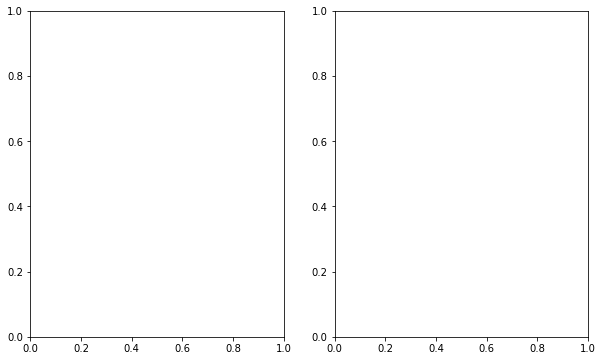

In [28]:
#                    x1 y1 x2 y2
edges = torch.Tensor([[0, 0, 20, 30]])
edges.requires_grad = True
opt = torch.optim.Adam([triangle], 5e-2)

# initialization function: plot the background of each frame
fig, (ax1, ax2) = plt.subplots(1, 2)

_loss, _loss_surf = edge_loss(edges, target)
trgt = ax1.imshow(target.detach(), cmap='coolwarm', alpha=0.3)
ins = ax2.imshow(_loss_surf.detach(), cmap='gray_r')
t = edges[0].detach()
line, = ax1.plot([t[1], t[3]], [t[0], t[2]], 'o-')

def init():
    t = edges[0].detach()
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    return (line, ins, )

def animate(i):
    for _ in range(2):
        opt.zero_grad()
        loss, _loss_surf = edge_loss(edges, target)
        loss.backward()
        opt.step()
    t = edges[0].detach()
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    ins.set_data(_loss_surf.detach())
    
    return (line, ins, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)